Universidad Torcuato Di Tella

Licenciatura en Tecnología Digital\
**Tecnología Digital VI: Inteligencia Artificial**

In [1]:
!pip install -Uq wandb


# TP3: Clasificador de imagenes


``torchvision`` contiene  data loaders para datasets conocidos como ImageNet, CIFAR10, MNIST, etc.
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

El dataset CIFAR10 contiene las siguientes clases: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
Las imagenes son de tamaño 3x32x32, i.e. imagenes de color de 3 canales (RGB) de 32x32 pixels en tamaño.


## Orden de pasos

0. Elijan GPU para que corra mas rapido (RAM --> change runtime type --> T4 GPU)
1. Cargamos los datos CIFAR10 y preparamos los sets de training, validation y test.
2. Definimos las redes. Una MLP, un una CNN
3. Definimos la loss
4. Entrenamos
5. Evaluamos en Test

### 1.Carga de datos CIFAR10


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.model_selection import train_test_split
import torch.utils.data
import numpy as np
import wandb

wandb.login()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

wandb: Currently logged in as: gaston-lm (carrostp3). Use `wandb login --relogin` to force relogin


cuda:0


In [3]:
torch.manual_seed(181988)
if torch.cuda.is_available():
    torch.cuda.manual_seed(181988)

In [4]:
#Parametros
batch_size = 32
learning_rate = 0.02
momentum = .9
epochs = 50
experiment_name = 'train_transfer_rn50_silu'
project_name = 'TP3'

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [5]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

#trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
targets_ = trainset.targets
train_idx, val_idx = train_test_split(np.arange(len(targets_)), test_size=0.2, stratify=targets_)
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sampler,batch_size=batch_size, num_workers=2)
valloader = torch.utils.data.DataLoader(trainset, sampler=val_sampler,batch_size=batch_size, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



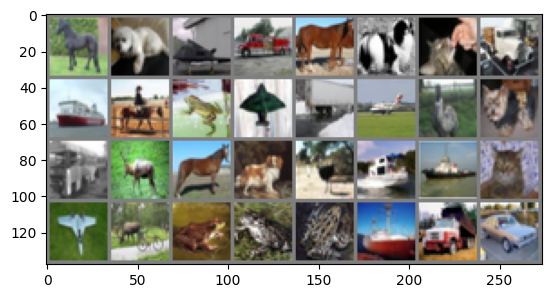

horse dog   plane truck horse dog   cat   truck ship  horse frog  plane truck plane bird  dog   truck deer  horse dog   bird  ship  ship  cat   plane deer  frog  frog  frog  ship  truck car  


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Definimos las redes



In [7]:
import torch.nn as nn
import torch.nn.functional as F

if experiment_name == 'default':
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32*3)
            self.fc21 = nn.Linear(32*32*3, 32*32)
            self.fc22 = nn.Linear(32*32, 120)
            self.fc23 = nn.Linear(120, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 10)

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    net = Net()

if experiment_name == '4_decreasing_layers':
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32*3)
            self.fc2 = nn.Linear(32*32*3, 84)
            self.fc3 = nn.Linear(84, 32)
            self.fc4 = nn.Linear(32, 10)

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
            x = self.fc4(x)
            return x

    net = Net()

if experiment_name == 'relu_layer_div4':
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 768)
            self.fc12 = nn.Linear(768, 192)
            self.fc23 = nn.Linear(192, 48)
            self.fc34 = nn.Linear(48, 12)
            self.fc4 = nn.Linear(12, 10)

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc12(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc34(x))
            x = self.fc4(x)
            return x

    net = Net()

if experiment_name == 'relu_layer_div2':
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(3072, 1536)
            self.fc12 = nn.Linear(1536, 768)
            self.fc23 = nn.Linear(768, 384)
            self.fc34 = nn.Linear(384, 192)
            self.fc45 = nn.Linear(192, 96)
            self.fc56 = nn.Linear(96, 48)
            self.fc67 = nn.Linear(48, 24)
            self.fc7 = nn.Linear(24, 10)

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc12(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc34(x))
            x = F.relu(self.fc45(x))
            x = F.relu(self.fc56(x))
            x = F.relu(self.fc67(x))
            x = self.fc7(x)
            return x

    net = Net()

if experiment_name == 'relu_layer_divrand':
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32)
            self.fc12 = nn.Linear(32*32, 512)
            self.fc23 = nn.Linear(512, 320)
            self.fc34 = nn.Linear(320, 120)
            self.fc45 = nn.Linear(120, 84)
            self.fc5 = nn.Linear(84, 10)

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc12(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc34(x))
            x = F.relu(self.fc45(x))
            x = self.fc5(x)
            return x

    net = Net()

if experiment_name == "relu_div4_div2":
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 768)
            self.fc21 = nn.Linear(768, 384)
            self.fc22 = nn.Linear(384, 96)
            self.fc23 = nn.Linear(96, 48)
            self.fc2 = nn.Linear(48, 12)
            self.fc3 = nn.Linear(12, 10)

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    net = Net()

if experiment_name == 'default_conv':
    class NetConv(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.fc1 = nn.Linear(16 * 5 * 5, 120)
            self.fc21 = nn.Linear(120, 120)
            self.fc22 = nn.Linear(120, 120)
            self.fc23 = nn.Linear(120, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 10)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    net = NetConv()

if experiment_name == 'simple_cnn':
  class NetConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

  net = NetConv()

if experiment_name == 'simple_cnn_arq_2':
  class NetConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 32)
        self.fc8 = nn.Linear(32, 16)
        self.fc9 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = self.fc9(x)
        return x

  net = NetConv()

if experiment_name == 'simple_cnn_arq_4':
  class NetConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 16)
        self.fc5 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

  net = NetConv()

if experiment_name == 'train_transfer_rn50':
  class NetConv(nn.Module):
      def __init__(self):
          super().__init__()

          # Load the ResNet-50 model with pre-trained weights
          self.resnet50 = models.resnet50(pretrained=True)

          # Modify the final classification layer to match the number of output classes
          num_features = self.resnet50.fc.in_features
          self.resnet50.fc = nn.Sequential(
              nn.Linear(num_features, 1024),
              nn.ReLU(),
              nn.Linear(1024, 256),
              nn.ReLU(),
              nn.Linear(256, 64),
              nn.ReLU(),
              nn.Linear(64, 16),
              nn.ReLU(),
              nn.Linear(16, 10)
          )

      def forward(self, x):
          x = self.resnet50(x)
          return x

  net = NetConv()

if experiment_name == 'train_transfer_rn50_leakyRelu':
  class NetConv(nn.Module):
      def __init__(self):
          super().__init__()

          # Load the ResNet-50 model with pre-trained weights
          self.resnet50 = models.resnet50(pretrained=True)

          # Modify the final classification layer to match the number of output classes
          num_features = self.resnet50.fc.in_features
          self.resnet50.fc = nn.Sequential(
              nn.Linear(num_features, 1024),
              nn.LeakyReLU(),
              nn.Linear(1024, 256),
              nn.LeakyReLU(),
              nn.Linear(256, 64),
              nn.LeakyReLU(),
              nn.Linear(64, 16),
              nn.LeakyReLU(),
              nn.Linear(16, 10)
          )

      def forward(self, x):
          x = self.resnet50(x)
          return x

  net = NetConv()

if experiment_name == 'train_transfer_rn50_sigmoid':
  class NetConv(nn.Module):
      def __init__(self):
          super().__init__()

          # Load the ResNet-50 model with pre-trained weights
          self.resnet50 = models.resnet50(pretrained=True)

          # Modify the final classification layer to match the number of output classes
          num_features = self.resnet50.fc.in_features
          self.resnet50.fc = nn.Sequential(
              nn.Linear(num_features, 1024),
              nn.Sigmoid(),
              nn.Linear(1024, 256),
              nn.Sigmoid(),
              nn.Linear(256, 64),
              nn.Sigmoid(),
              nn.Linear(64, 16),
              nn.Sigmoid(),
              nn.Linear(16, 10)
          )

      def forward(self, x):
          x = self.resnet50(x)
          return x

  net = NetConv()

if experiment_name == 'train_transfer_rn50_elu':
  class NetConv(nn.Module):
      def __init__(self):
          super().__init__()

          # Load the ResNet-50 model with pre-trained weights
          self.resnet50 = models.resnet50(pretrained=True)

          # Modify the final classification layer to match the number of output classes
          num_features = self.resnet50.fc.in_features
          self.resnet50.fc = nn.Sequential(
              nn.Linear(num_features, 1024),
              nn.ELU(),
              nn.Linear(1024, 256),
              nn.ELU(),
              nn.Linear(256, 64),
              nn.ELU(),
              nn.Linear(64, 16),
              nn.ELU(),
              nn.Linear(16, 10)
          )

      def forward(self, x):
          x = self.resnet50(x)
          return x

  net = NetConv()

if experiment_name == 'train_transfer_rn50_silu':
  class NetConv(nn.Module):
      def __init__(self):
          super().__init__()

          # Load the ResNet-50 model with pre-trained weights
          self.resnet50 = models.resnet50(pretrained=True)

          # Modify the final classification layer to match the number of output classes
          num_features = self.resnet50.fc.in_features
          self.resnet50.fc = nn.Sequential(
              nn.Linear(num_features, 1024),
              nn.SiLU(),
              nn.Linear(1024, 256),
              nn.SiLU(),
              nn.Linear(256, 64),
              nn.SiLU(),
              nn.Linear(64, 16),
              nn.SiLU(),
              nn.Linear(16, 10)
          )

      def forward(self, x):
          x = self.resnet50(x)
          return x

  net = NetConv()

net.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NetConv(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

### 3. Definimos la loss y el optimizador




In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

### 4. Entrenamos

Deberiamos plotear la loss para el validation set tb!



In [9]:
wandb.init(
    # set the wandb project where this run will be logged
    project=project_name,
    name = experiment_name,
    # track hyperparameters and run metadata
    config={
        "learning_rate": learning_rate,
        "momentum": momentum,
        "batch_size": batch_size,
        "epochs": epochs,
    }
)

In [10]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    train_correct =0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')


        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_correct += (predicted == labels).sum().item()


    # End of test section
    # Val section
    train_accuracy = 100 * train_correct / total
    running_loss = running_loss/total

    val_correct = 0
    total =0
    val_loss =0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    # End of test section

    val_accuracy = 100 * val_correct /total
    val_loss = val_loss / total

    wandb.log({ "train_accuracy": train_accuracy, "val_accuracy": val_accuracy, "train_loss": running_loss,
             "val_loss": val_loss})

print('Finished Training')

[1,   200] loss: 0.224
[1,   400] loss: 0.412
[1,   600] loss: 0.579
[1,   800] loss: 0.729
[1,  1000] loss: 0.868
[1,  1200] loss: 0.998
[2,   200] loss: 0.117
[2,   400] loss: 0.231
[2,   600] loss: 0.336
[2,   800] loss: 0.441
[2,  1000] loss: 0.540
[2,  1200] loss: 0.637
[3,   200] loss: 0.092
[3,   400] loss: 0.179
[3,   600] loss: 0.269
[3,   800] loss: 0.354
[3,  1000] loss: 0.439
[3,  1200] loss: 0.521
[4,   200] loss: 0.077
[4,   400] loss: 0.150
[4,   600] loss: 0.222
[4,   800] loss: 0.297
[4,  1000] loss: 0.370
[4,  1200] loss: 0.441
[5,   200] loss: 0.067
[5,   400] loss: 0.132
[5,   600] loss: 0.198
[5,   800] loss: 0.262
[5,  1000] loss: 0.325
[5,  1200] loss: 0.387
[6,   200] loss: 0.058
[6,   400] loss: 0.122
[6,   600] loss: 0.183
[6,   800] loss: 0.263
[6,  1000] loss: 0.334
[6,  1200] loss: 0.412
[7,   200] loss: 0.058
[7,   400] loss: 0.116
[7,   600] loss: 0.174
[7,   800] loss: 0.232
[7,  1000] loss: 0.288
[7,  1200] loss: 0.344
[8,   200] loss: 0.050
[8,   400] 

Ejemplo de guardar el modelo. Sin embargo lo deberiamos guardar para el que mejor dio en validation.



In [11]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)



### 5. Una vez elegido todos los hyper-parametros, evaluar el mejor modelo en Test




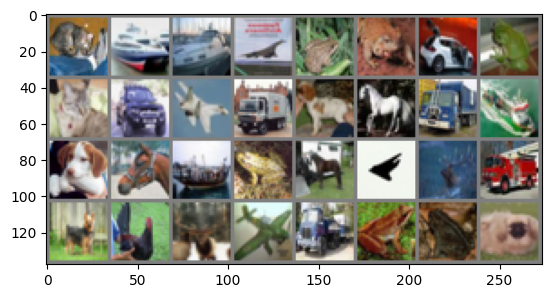

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog  


In [12]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Cargamos el modelo (el mejor) y evaluamos en un ejemplo


In [13]:
net = NetConv()
net.load_state_dict(torch.load(PATH))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane



Evaluamos en el set de test



In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 83 %


Algo estamos aprendiendo! Si fuese random, seria 10% accuracy (elegir random entre 10 clases).
Algunas clases se comportan peor que otras.


In [15]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 90.2 %
Accuracy for class: car   is 88.9 %
Accuracy for class: bird  is 76.3 %
Accuracy for class: cat   is 68.8 %
Accuracy for class: deer  is 78.6 %
Accuracy for class: dog   is 75.5 %
Accuracy for class: frog  is 87.1 %
Accuracy for class: horse is 89.3 %
Accuracy for class: ship  is 90.3 %
Accuracy for class: truck is 87.2 %
